In [10]:
import pandas as pd
import yfinance as yf
import datetime
import requests
import json

In [11]:
# Get the company name given ticker/symbol name
yfinance = "https://query2.finance.yahoo.com/v1/finance/search"
user_agent = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36"
params = {"q": "APPL", "quotes_count": 1, "country": "United States"}

res = requests.get(
    url=yfinance, params=params, headers={"User-Agent": user_agent}
)
data = res.json()
data

{'explains': [],
 'count': 17,
 'quotes': [{'exchange': 'NMS',
   'shortname': 'Apple Inc.',
   'quoteType': 'EQUITY',
   'symbol': 'AAPL',
   'index': 'quotes',
   'score': 223940.0,
   'typeDisp': 'Equity',
   'longname': 'Apple Inc.',
   'exchDisp': 'NASDAQ',
   'sector': 'Technology',
   'sectorDisp': 'Technology',
   'industry': 'Consumer Electronics',
   'industryDisp': 'Consumer Electronics',
   'dispSecIndFlag': True,
   'isYahooFinance': True},
  {'exchange': 'NMS',
   'shortname': 'Applied Materials, Inc.',
   'quoteType': 'EQUITY',
   'symbol': 'AMAT',
   'index': 'quotes',
   'score': 32498.0,
   'typeDisp': 'Equity',
   'longname': 'Applied Materials, Inc.',
   'exchDisp': 'NASDAQ',
   'sector': 'Technology',
   'sectorDisp': 'Technology',
   'industry': 'Semiconductor Equipment & Materials',
   'industryDisp': 'Semiconductor Equipment & Materials',
   'isYahooFinance': True},
  {'exchange': 'NGM',
   'shortname': 'Applied Optoelectronics, Inc.',
   'quoteType': 'EQUITY',


In [12]:
ticker = data["quotes"][0]["symbol"]
name = data["quotes"][0]["shortname"]
stock = yf.Ticker(ticker)
stock.history(period="5D")

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-08-08 00:00:00-04:00,179.447673,180.026893,177.340518,179.557526,67823000,0.00,0.0
2023-08-09 00:00:00-04:00,180.626086,180.686002,176.771290,177.949707,60378500,0.00,0.0
2023-08-10 00:00:00-04:00,179.237954,180.506245,177.360500,177.729996,54686900,0.00,0.0
2023-08-11 00:00:00-04:00,177.320007,178.619995,176.550003,177.789993,51988100,0.24,0.0
2023-08-14 00:00:00-04:00,177.970001,179.690002,177.304993,179.460007,43542592,0.00,0.0


In [13]:
stock.history(period="5D", interval="5h")

AAPL: Invalid input - interval=5h is not supported. Valid intervals: , 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo]


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,


In [14]:
hist = stock.history(period="5D", interval="1d")
hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-08-08 00:00:00-04:00,179.447673,180.026893,177.340518,179.557526,67823000,0.00,0.0
2023-08-09 00:00:00-04:00,180.626086,180.686002,176.771290,177.949707,60378500,0.00,0.0
2023-08-10 00:00:00-04:00,179.237954,180.506245,177.360500,177.729996,54686900,0.00,0.0
2023-08-11 00:00:00-04:00,177.320007,178.619995,176.550003,177.789993,51988100,0.24,0.0
2023-08-14 00:00:00-04:00,177.970001,179.690002,177.304993,179.460007,43542592,0.00,0.0


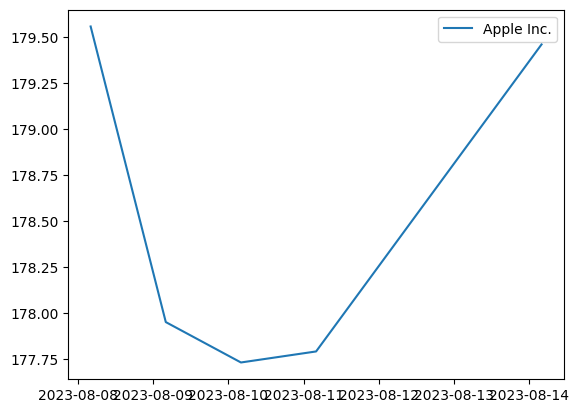

In [15]:
import matplotlib.pyplot as plt
plt.plot(hist.index.values, hist["Close"], label=name)
plt.legend(loc="upper right")

In [16]:
data = hist[["Open", "Close", "Low", "High"]].round(2).copy()
data

,Open,Close,Low,High
Date,,,,
2023-08-08 00:00:00-04:00,179.45,179.56,177.34,180.03
2023-08-09 00:00:00-04:00,180.63,177.95,176.77,180.69
2023-08-10 00:00:00-04:00,179.24,177.73,177.36,180.51
2023-08-11 00:00:00-04:00,177.32,177.79,176.55,178.62
2023-08-14 00:00:00-04:00,177.97,179.46,177.30,179.69


In [17]:
[type(x) for x in data.index.values]

[numpy.datetime64,
 numpy.datetime64,
 numpy.datetime64,
 numpy.datetime64,
 numpy.datetime64]

In [18]:
json_format_data = data.to_json(orient="split", date_format="epoch")
result = json.loads(json_format_data)
result

{'columns': ['Open', 'Close', 'Low', 'High'],
 'index': [1691467200000,
  1691553600000,
  1691640000000,
  1691726400000,
  1691985600000],
 'data': [[179.45, 179.56, 177.34, 180.03],
  [180.63, 177.95, 176.77, 180.69],
  [179.24, 177.73, 177.36, 180.51],
  [177.32, 177.79, 176.55, 178.62],
  [177.97, 179.46, 177.3, 179.69]]}

In [19]:
data['index'] = [datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d")for x in result["index"]]
data

,Open,Close,Low,High,index
Date,,,,,
2023-08-08 00:00:00-04:00,179.45,179.56,177.34,180.03,2023-08-08
2023-08-09 00:00:00-04:00,180.63,177.95,176.77,180.69,2023-08-09
2023-08-10 00:00:00-04:00,179.24,177.73,177.36,180.51,2023-08-10
2023-08-11 00:00:00-04:00,177.32,177.79,176.55,178.62,2023-08-11
2023-08-14 00:00:00-04:00,177.97,179.46,177.30,179.69,2023-08-14


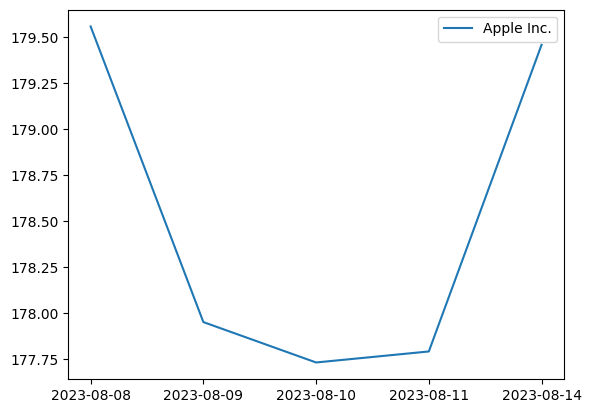

In [20]:
plt.plot(data["index"], data["Close"], label=name)
plt.legend(loc="upper right")

In [21]:
# Moving average
def moving_average(data, time_period):
    data[str(time_period) + "D-SMA"] = (
        data["Close"].rolling(window=time_period).mean().round(2)
    )

In [22]:
moving_average(data, 3)
data

,Open,Close,Low,High,index,3D-SMA
Date,,,,,,
2023-08-08 00:00:00-04:00,179.45,179.56,177.34,180.03,2023-08-08,NaN
2023-08-09 00:00:00-04:00,180.63,177.95,176.77,180.69,2023-08-09,NaN
2023-08-10 00:00:00-04:00,179.24,177.73,177.36,180.51,2023-08-10,178.41
2023-08-11 00:00:00-04:00,177.32,177.79,176.55,178.62,2023-08-11,177.82
2023-08-14 00:00:00-04:00,177.97,179.46,177.30,179.69,2023-08-14,178.33


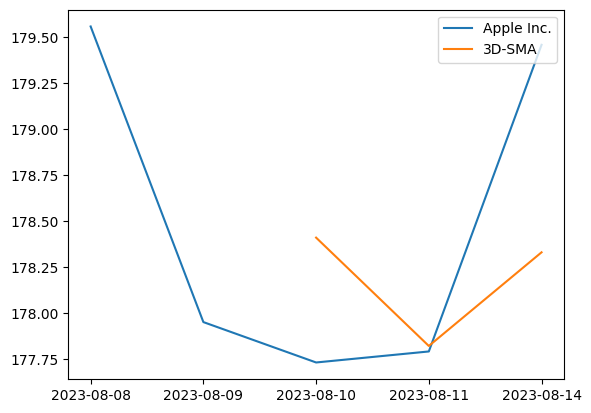

In [23]:
plt.plot(data["index"], data["Close"],label=name)
plt.plot(data["index"], data["3D-SMA"], label="3D-SMA")
plt.legend(loc="upper right")

In [25]:
# S&P 500 Tickers
tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
tickers

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...
498,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
499,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
500,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927
501,ZION,Zions Bancorporation,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,109380,1873


In [26]:
data = yf.download(tickers.Symbol.to_list(),'2022-8-8','2023-8-5', auto_adjust=True)['Close']
data

[*********************100%***********************]  503 of 503 completed

2 Failed downloads:
- BF.B: No data found for this date range, symbol may be delisted
- BRK.B: No timezone found, symbol may be delisted


,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2022-08-08,131.627853,15.02,187.541779,163.897690,134.868530,138.562912,106.949158,44.150002,305.385590,434.339996,...,65.740631,71.742546,85.977158,36.420670,98.433838,116.303284,112.292343,330.320007,51.953251,172.483398
2022-08-09,128.012375,14.62,185.109314,163.947403,134.782043,142.602936,105.879669,44.650002,304.854187,426.570007,...,65.880310,72.635696,87.562347,35.751137,96.843651,114.762375,111.627472,320.149994,52.471920,168.062531
2022-08-10,131.687439,15.07,187.927902,168.241943,135.445129,143.450378,108.195259,45.230000,311.437622,438.399994,...,65.201851,72.917213,88.393608,36.469902,99.243752,116.970673,114.088463,328.869995,54.162392,172.532959
2022-08-11,131.061676,14.99,190.563065,167.496353,136.540695,146.051743,108.411118,45.980000,309.410400,434.890015,...,67.416824,72.431808,90.950653,36.597900,99.895630,115.527916,114.118233,336.000000,54.988422,171.660690
2022-08-12,132.650894,15.25,195.495575,171.085068,137.040436,148.760056,109.382492,47.040001,315.334503,445.670013,...,68.584167,73.742409,91.741180,37.070511,102.108070,115.969582,116.321213,346.739990,55.920101,174.128845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-31,121.769997,16.75,74.389999,196.185074,149.580002,186.411896,111.330002,77.690002,316.350006,546.169983,...,108.980003,62.730000,107.239998,41.520000,112.750000,137.669998,138.149994,307.959991,38.250000,188.089996
2023-08-01,122.480003,16.23,73.720001,195.346207,148.539993,188.606155,110.529999,77.099998,320.970001,549.099976,...,109.139999,62.849998,106.620003,41.369999,111.930000,136.360001,132.270004,254.770004,37.099998,185.509995
2023-08-02,127.709999,15.95,69.639999,192.320297,149.380005,190.930054,108.620003,77.360001,317.779999,530.299988,...,105.160004,62.880001,105.290001,40.669998,112.080002,135.000000,128.380005,241.149994,36.630001,182.000000


In [27]:
df = data
df['Date'] = [x.strftime('%Y-%m-%d') for x in df.index.values]
df

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS,Date
Date,,,,,,,,,,,,,,,,,,,,,
2022-08-08,131.627853,15.02,187.541779,163.897690,134.868530,138.562912,106.949158,44.150002,305.385590,434.339996,...,71.742546,85.977158,36.420670,98.433838,116.303284,112.292343,330.320007,51.953251,172.483398,2022-08-08
2022-08-09,128.012375,14.62,185.109314,163.947403,134.782043,142.602936,105.879669,44.650002,304.854187,426.570007,...,72.635696,87.562347,35.751137,96.843651,114.762375,111.627472,320.149994,52.471920,168.062531,2022-08-09
2022-08-10,131.687439,15.07,187.927902,168.241943,135.445129,143.450378,108.195259,45.230000,311.437622,438.399994,...,72.917213,88.393608,36.469902,99.243752,116.970673,114.088463,328.869995,54.162392,172.532959,2022-08-10
2022-08-11,131.061676,14.99,190.563065,167.496353,136.540695,146.051743,108.411118,45.980000,309.410400,434.890015,...,72.431808,90.950653,36.597900,99.895630,115.527916,114.118233,336.000000,54.988422,171.660690,2022-08-11
2022-08-12,132.650894,15.25,195.495575,171.085068,137.040436,148.760056,109.382492,47.040001,315.334503,445.670013,...,73.742409,91.741180,37.070511,102.108070,115.969582,116.321213,346.739990,55.920101,174.128845,2022-08-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-31,121.769997,16.75,74.389999,196.185074,149.580002,186.411896,111.330002,77.690002,316.350006,546.169983,...,62.730000,107.239998,41.520000,112.750000,137.669998,138.149994,307.959991,38.250000,188.089996,2023-07-31
2023-08-01,122.480003,16.23,73.720001,195.346207,148.539993,188.606155,110.529999,77.099998,320.970001,549.099976,...,62.849998,106.620003,41.369999,111.930000,136.360001,132.270004,254.770004,37.099998,185.509995,2023-08-01
2023-08-02,127.709999,15.95,69.639999,192.320297,149.380005,190.930054,108.620003,77.360001,317.779999,530.299988,...,62.880001,105.290001,40.669998,112.080002,135.000000,128.380005,241.149994,36.630001,182.000000,2023-08-02


In [28]:
df.set_index('Date', inplace=True, drop=True)
df.to_csv("s&p500.csv")

In [29]:
df = pd.read_csv("s&p500.csv")
df

,Date,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
0,2022-08-08,131.627853,15.02,187.541779,163.897690,134.868530,138.562912,106.949158,44.150002,305.385590,...,65.740631,71.742546,85.977158,36.420670,98.433838,116.303284,112.292343,330.320007,51.953251,172.483398
1,2022-08-09,128.012375,14.62,185.109314,163.947403,134.782043,142.602936,105.879669,44.650002,304.854187,...,65.880310,72.635696,87.562347,35.751137,96.843651,114.762375,111.627472,320.149994,52.471920,168.062531
2,2022-08-10,131.687439,15.07,187.927902,168.241943,135.445129,143.450378,108.195259,45.230000,311.437622,...,65.201851,72.917213,88.393608,36.469902,99.243752,116.970673,114.088463,328.869995,54.162392,172.532959
3,2022-08-11,131.061676,14.99,190.563065,167.496353,136.540695,146.051743,108.411118,45.980000,309.410400,...,67.416824,72.431808,90.950653,36.597900,99.895630,115.527916,114.118233,336.000000,54.988422,171.660690
4,2022-08-12,132.650894,15.25,195.495575,171.085068,137.040436,148.760056,109.382492,47.040001,315.334503,...,68.584167,73.742409,91.741180,37.070511,102.108070,115.969582,116.321213,346.739990,55.920101,174.128845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,2023-07-31,121.769997,16.75,74.389999,196.185074,149.580002,186.411896,111.330002,77.690002,316.350006,...,108.980003,62.730000,107.239998,41.520000,112.750000,137.669998,138.149994,307.959991,38.250000,188.089996
246,2023-08-01,122.480003,16.23,73.720001,195.346207,148.539993,188.606155,110.529999,77.099998,320.970001,...,109.139999,62.849998,106.620003,41.369999,111.930000,136.360001,132.270004,254.770004,37.099998,185.509995
247,2023-08-02,127.709999,15.95,69.639999,192.320297,149.380005,190.930054,108.620003,77.360001,317.779999,...,105.160004,62.880001,105.290001,40.669998,112.080002,135.000000,128.380005,241.149994,36.630001,182.000000
248,2023-08-03,125.050003,15.98,72.029999,190.912201,149.050003,190.860245,107.540001,77.389999,317.130005,...,105.610001,61.320000,107.120003,39.279999,108.400002,135.619995,125.790001,249.550003,37.410000,180.880005


In [30]:
BFB = pd.read_csv("BFB.csv")
BFB = BFB[['Date', 'Close/Last']].rename(columns={'Close/Last': 'BF.B'})
BFB['Date'] = pd.to_datetime(BFB['Date'])
BFB = BFB.sort_values('Date')
BFB['BF.B'] = BFB['BF.B'].replace('[\$,]', '', regex=True).astype(float)
BFB

,Date,BF.B
249,2022-08-08,74.26
248,2022-08-09,75.43
247,2022-08-10,75.93
246,2022-08-11,75.40
245,2022-08-12,76.14
...,...,...
4,2023-07-31,70.60
3,2023-08-01,70.81
2,2023-08-02,70.59
1,2023-08-03,70.38


In [31]:
BRKB = pd.read_csv("BRKB.csv")
BRKB = BRKB[['Date', 'Close/Last']].rename(columns={'Close/Last': 'BRK.B'})
BRKB['Date'] = pd.to_datetime(BRKB['Date'])
BRKB = BRKB.sort_values('Date')
BRKB['BRK.B'] = BRKB['BRK.B'].replace('[\$,]', '', regex=True).astype(float)
BRKB

,Date,BRK.B
249,2022-08-08,292.34
248,2022-08-09,292.77
247,2022-08-10,295.11
246,2022-08-11,296.47
245,2022-08-12,301.55
...,...,...
4,2023-07-31,351.96
3,2023-08-01,352.26
2,2023-08-02,351.19
1,2023-08-03,353.81


In [32]:
df['BF.B'] = BFB['BF.B']
df['BRK.B'] = BRKB['BRK.B']
df.to_csv("s&p500.csv")